<center><h1>Probabilistic Programming in Quantitative Finance</h1><br>
<h3>Thomas Wiecki</h3><br>
<h3>@twiecki</h3><br>
<img width=40% src="http://i2.wp.com/stuffled.com/wp-content/uploads/2014/09/Quantopian-Logo-EPS-vector-image.png?resize=1020%2C680">
</center>

# About me

* Lead Data Scientist at [Quantopian Inc](https://www.quantopian.com): Building a crowd sourced hedge fund.
* Previous: PhD from Brown University -- research on computational neuroscience and machine learning using Bayesian modeling.

In [21]:
%pylab --no-import-all inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import scipy as sp
import pymc3 as pm
import theano.tensor as T

from scipy import stats
import scipy

data0 = pd.read_csv('data0.csv', index_col=0, parse_dates=True, header=None)[1]
data1 = pd.read_csv('data1.csv', index_col=0, parse_dates=True, header=None)[1]

def var_cov_var_t(P, c, nu=1, mu=0, sigma=1, **kwargs):
    """
    Variance-Covariance calculation of daily Value-at-Risk
    using confidence level c, with mean of returns mu
    and standard deviation of returns sigma, on a portfolio
    of value P.
    """
    alpha = stats.t.ppf(1-c, nu, mu, sigma)
    return P - P*(alpha + 1)

def var_cov_var_normal(P, c, mu=0, sigma=1, **kwargs):
    """
    Variance-Covariance calculation of daily Value-at-Risk
    using confidence level c, with mean of returns mu
    and standard deviation of returns sigma, on a portfolio
    of value P.
    """
    alpha = stats.norm.ppf(1-c, mu, sigma)
    return P - P*(alpha + 1)

def sample_normal(mu=0, sigma=1, **kwargs):
    samples = stats.norm.rvs(mu, sigma, kwargs.get('size', 100))
    return samples

def sample_t(nu=1, mu=0, sigma=1, **kwargs):
    samples = stats.t.rvs(nu, mu, sigma, kwargs.get('size', 100))
    return samples

def eval_normal(mu=0, sigma=1, **kwargs):
    pdf = stats.norm(mu, sigma).pdf(kwargs.get('x', np.linspace(-0.05, 0.05, 500)))
    return pdf

def eval_t(nu=1, mu=0, sigma=1, **kwargs):
    samples = stats.t(nu, mu, sigma).pdf(kwargs.get('x', np.linspace(-0.05, 0.05, 500)))
    return samples

def logp_normal(mu=0, sigma=1, **kwargs):
    logp = np.sum(stats.norm(mu, sigma).logpdf(kwargs['data']))
    return logp

def logp_t(nu=1, mu=0, sigma=1, **kwargs):
    logp = np.sum(stats.t(nu, mu, sigma).logpdf(kwargs['data']))
    return logp

# generate posterior predictive
def post_pred(func, trace, *args, **kwargs):
    samples = kwargs.pop('samples', 50)
    ppc = []
    for i, idx in enumerate(np.linspace(0, len(trace), samples)):
        t = trace[int(i)]
        try:
            kwargs['nu'] = t['nu_minus_one']+1
        except KeyError:
            pass
        mu = t['mean returns']
        sigma = t['volatility']
        ppc.append(func(*args, mu=mu, sigma=sigma, **kwargs))

    return ppc

def plot_strats(sharpe=False):
    figsize(12, 6)
    f, (ax1, ax2) = plt.subplots(1, 2)
    if sharpe:
        label = 'etrade\nn=%i\nSharpe=%.2f' % (len(data_0), (data_0.mean() / data_0.std() * np.sqrt(252)))
    else:
        label = 'etrade\nn=%i\n' % (len(data_0))
    sns.distplot(data_0, kde=False, ax=ax1, label=label, color='b')
    ax1.set_xlabel('daily returns'); ax1.legend(loc=0)
    if sharpe:
        label = 'IB\nn=%i\nSharpe=%.2f' % (len(data_1), (data_1.mean() / data_1.std() * np.sqrt(252)))
    else:
        label = 'IB\nn=%i\n' % (len(data_1))
    sns.distplot(data_1, kde=False, ax=ax2, label=label, color='g')
    ax2.set_xlabel('daily returns'); ax2.legend(loc=0);

Populating the interactive namespace from numpy and matplotlib


In [23]:
def model_returns_normal(data):
    with pm.Model() as model:
        mu = pm.Normal('mean returns', mu=0, sd=.01, testval=data.mean())
        sigma, log_sigma = model.TransformedVar('volatility', 
                                                pm.HalfCauchy.dist(beta=1, testval=data.std()), 
                                                pm.transforms.logtransform)
        #sigma = pm.HalfCauchy('volatility', beta=.1, testval=data.std())
        returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
        ann_vol = pm.Deterministic('annual volatility', returns.distribution.variance**.5 * np.sqrt(252))
        sharpe = pm.Deterministic('sharpe', 
                                  returns.distribution.mean / returns.distribution.variance**.5 * np.sqrt(252))
        start = pm.find_MAP(fmin=scipy.optimize.fmin_powell)
        step = pm.NUTS(scaling=start)
        trace_normal = pm.sample(5000, step, start=start)
    return trace_normal

def model_returns_t(data):
    with pm.Model() as model:
        mu = pm.Normal('mean returns', mu=0, sd=.01, testval=data.mean())
        sigma, log_sigma = model.TransformedVar('volatility', 
                                                pm.HalfCauchy.dist(beta=1, testval=data.std()), 
                                                pm.transforms.logtransform)
        nu, log_nu = model.TransformedVar('nu_minus_one',
                                          pm.Exponential.dist(1./10., testval=3.),
                                          pm.transforms.logtransform)

        returns = pm.T('returns', nu=nu+2, mu=mu, sd=sigma, observed=data)
        ann_vol = pm.Deterministic('annual volatility', returns.distribution.variance**.5 * np.sqrt(252))
        sharpe = pm.Deterministic('sharpe', 
                                  returns.distribution.mean / returns.distribution.variance**.5 * np.sqrt(252))

        start = pm.find_MAP(fmin=scipy.optimize.fmin_powell)
        step = pm.NUTS(scaling=start)
        trace = pm.sample(5000, step, start=start)

    return trace

def model_returns_t_stoch_vol(data):
    from pymc3.distributions.timeseries import GaussianRandomWalk

    with pm.Model() as model:
        mu = pm.Normal('mean returns', mu=0, sd=.01, testval=data.mean())
        step_size, log_step_size = model.TransformedVar('step size', 
                                                pm.Exponential.dist(1./.02, testval=.06), 
                                                pm.transforms.logtransform)
        
        vol = GaussianRandomWalk('volatility', step_size**-2, shape=len(data))
        
        nu, log_nu = model.TransformedVar('nu_minus_one',
                                          pm.Exponential.dist(1./10., testval=3.),
                                          pm.transforms.logtransform)

        returns = pm.T('returns', nu=nu+2, mu=mu, lam=pm.exp(-2*vol), observed=data)
        #ann_vol = pm.Deterministic('annual volatility', returns.distribution.variance**.5 * np.sqrt(252))
        #sharpe = pm.Deterministic('sharpe', 
        #                          returns.distribution.mean / ann_vol)

        start = pm.find_MAP(vars=[vol], fmin=sp.optimize.fmin_l_bfgs_b)
        #start = pm.find_MAP(fmin=scipy.optimize.fmin_powell, start=start)
        step = pm.NUTS(scaling=start)
        trace = pm.sample(5000, step, start=start)

    return trace

 [-----------------100%-----------------] 5000 of 5000 complete in 6.3 sec

/home/wiecki/envs/pymc3/local/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


TypeError: __init__() got an unexpected keyword argument 'sd'

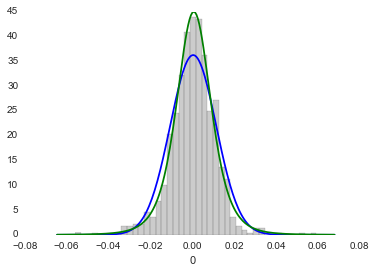

In [25]:
def calc_scores(data, data_live, normal=False):
    # Run models
    if normal:
        trace = model_returns_normal(data)
        if data_live is not None:
            trace_live = model_returns_normal(data_live)
    else:
        trace = model_returns_t(data)
        if data_live is not None:
            trace_live = model_returns_t(data_live)
    
    # Run PPC
    x = np.linspace(-0.05, 0.05, 500)
    if normal:
        ppc_bt = post_pred(eval_normal, trace, samples=500, x=x)
        if data_live is not None:
            ppc_live = post_pred(eval_normal, trace_live, samples=500, x=x)
    else:
        ppc_bt = post_pred(eval_t, trace, samples=500, x=x)
        if data_live is not None:
            ppc_live = post_pred(eval_t, trace_live, samples=500, x=x)

    # Calc KL div
    if data_live is not None:
        kl_div = []
        for b, l in zip(ppc_bt, ppc_live):
            kl_div.append(scipy.stats.entropy(b, l))

    if data_live is not None:
        return trace, trace_live, ppc_bt, ppc_live, kl_div
    else: 
        return trace, None, ppc_bt, None, None
    
results_normal = {}
results_t = {}
data_0, _ = get_data(0)
data_0 = data_0.iloc[-804:]
data_1, _ = get_data(5)
data_1 = data_1.iloc[-400:]
for anon_id, data in zip([0, 1], [data_0, data_1]):
    sns.distplot(data, label='data', kde=False, color='.5')
    sns.distplot(data, label='Normal', fit=stats.norm, kde=False, hist=False, fit_kws={'color': 'b', 'label': 'Normal'})
    sns.distplot(data, fit=stats.t, kde=False, hist=False, fit_kws={'color': 'g', 'label': 'T'})

    trace_normal, trace_normal_live, ppc_bt, ppc_live, kl_div = calc_scores(data, data_live, normal=True)
    results_normal[anon_id] = (trace_normal, trace_normal_live, ppc_bt, ppc_live, kl_div)

    trace_t, trace_t_live, ppc_bt, ppc_live, kl_div = calc_scores(data, data_live)
    results_t[anon_id] = (trace_t, trace_t_live, ppc_bt, ppc_live, kl_div)
    
    print data.mean() / data.std() * np.sqrt(252)

In [ ]:
from IPython.display import Image
sns.set_context('talk', font_scale=1.5)
sns.set_context(rc={'lines.markeredgewidth': 0.1})
from matplotlib import rc
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14)
figsize(10, 6)

# Data Science Motivation

<center><img src="model-inference1.svg">

<center><img src="model-inference2.svg">

# What's wrong with statistics

* Models should not be built for mathematical convenience (e.g. normality assumption), but to most accurately model the data.
* Pre-specified models, like frequentist statistics, make many assumptions that are all to easily violated.

<center><img src="general_vs_insight_wo_pp.svg">

<center><img src="general_vs_insight.svg">

# "The purpose of computation is insight, not numbers." -- Richard Hamming
<center><img src="http://upload.wikimedia.org/wikipedia/en/0/08/Richard_Hamming.jpg">

# Quantitative Finance motivation

# <center>Types of risk</center>

<center><img src="risk_first.svg"></center>

# <center>Types of risk</center>

<center><img src="risk_full.svg"></center>

# Probabilistic Programming

* Model **unknown causes** of a phenomenon as **random variables**.
* Write a **programmatic story** in **code** of how **unknown causes** result in **observable data** -> **generative framework**
* Use **Bayes formula** to invert generative model to infer **unknown causes**.
* Inference is **completely automatic** (when things go well)!
* -> No math, great flexibility and freedom when building models.
* The catch: At the cost of increased computational demands. 

# Motivating the problem we face at Quantopian

# Web based backtester for trading algorithms & live trading
<center><img src='quantopian.png' width=85%>

# Crowd sourced hedge fund

* "15 uncorrelated return streams are the holy grail of investing"
* -> Search for diverse trading strategies.
* Perfect problem for crowd sourcing!

# Our problem today

* How do we identify the best trading algorithms?

## Monthly trading competitions -- win, and we'll invest $100k, you keep all the profits
<center><img src='contest.png'>

# Let's take just two strategies and try to pick the better one

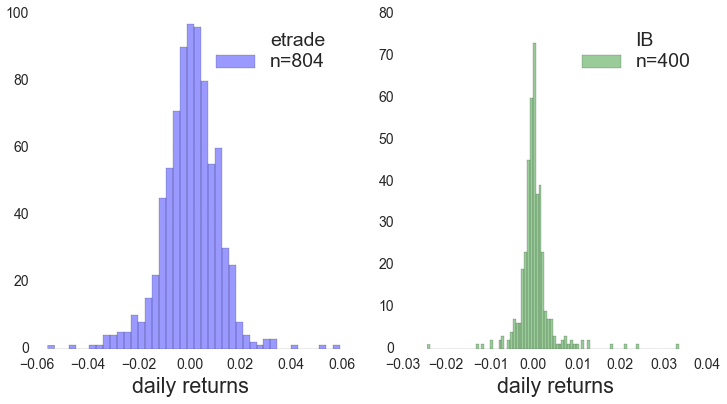

In [76]:
plot_strats()

# Sharpe Ratio

$$\text{Sharpe} = \frac{\text{mean returns}}{\text{volatility}}$$

In [24]:
print "Sharpe ratio strategy etrade =", data_0.mean() / data_0.std() * np.sqrt(252)
print "Sharpe ratio strategy IB =", data_1.mean() / data_1.std() * np.sqrt(252)

Sharpe ratio strategy etrade = 0.627893606355
Sharpe ratio strategy IB = 1.43720181575


# Detour ahead

# Short primer on random variables

* Represents our beliefs about an unknown state.
* Probability distribution assigns a probability to each possible state.
* **Not** a single number (e.g. most likely state).

## You already know what a variable is...

In [8]:
coin = 0 # 0 for tails
coin = 1 # 1 for heads

## A random variable assigns all possible values a certain probability

In [ ]:
coin = {0: 50%,
        1: 50%}

### Alternatively:

coin ~ Bernoulli(p=0.5)

* `coin` is a random variable
* `Bernoulli` is a probability distribution
* `~` reads as "is distributed as"

## This was discrete (binary), what about the continuous case?

returns ~ Normal($\mu$, $\sigma^2$)

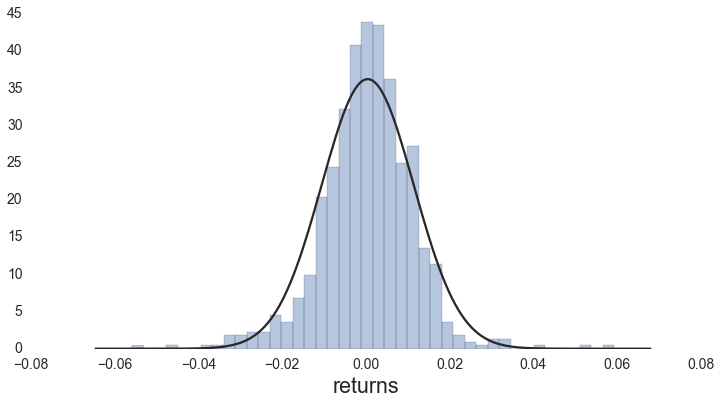

In [77]:
from scipy import stats
sns.distplot(data_0, kde=False, fit=stats.norm)
plt.xlabel('returns')

# How to estimate $\mu$ and $\sigma$?

* Naive: point estimate
* Set `mu = mean(data)` and `sigma = std(data)`
* Maximum Likelihood Estimate
* Correct answer as $n \rightarrow \infty$

# Bayesian analysis
* Most of the time $n \neq \infty$...
* *Uncertainty* about $\mu$ and $\sigma$
* Turn $\mu$ and $\sigma$ into random variables
* How to estimate?

# Bayes Formula!

<img src="bayes_formula.svg">

Use prior knowledge and data to update our *beliefs*.

In [4]:
figsize(7, 7)
from IPython.html.widgets import interact, interactive
from scipy import stats
def gen_plot(n=0, bayes=False):
    np.random.seed(3)
    x = np.random.randn(n)
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    #fig, (ax1, ax2, ax3, _) = plt.subplots(2, 2)
    if n > 1:
        sns.distplot(x, kde=False, ax=ax3, rug=True, hist=False)
    
    def gen_post_mu(x, mu0=0, sigma0=5):
        mu = np.mean(x)
        sigma = 1
        n = len(x)
        
        if n == 0:
            post_mu = mu0
            post_sigma = sigma0
        else:
            post_mu = (mu0 / sigma0**2 + np.sum(x) / sigma0**2) / (1/sigma0**2 + n/sigma**2)
            post_sigma = (1 / sigma0**2 + n / sigma**2)**-1
        return stats.norm(post_mu, post_sigma**2)
    
    def gen_post_var(x, alpha0, beta0):
        mu = 0
        sigma = np.std(x)
        n = len(x)
        post_alpha = alpha0 + n / 2
        post_beta = beta0 + np.sum((x - mu)**2) / 2
        return stats.invgamma(post_alpha, post_beta)
    
    
    mu_lower = -.3
    mu_upper = .3
    
    sigma_lower = 0
    sigma_upper = 3
    ax2.set_xlim((2, n+1))#(sigma_lower, sigma_upper))
    ax1.axvline(0, lw=.5, color='k')
    #ax2.axvline(1, lw=.5, color='k')
    ax2.axhline(0, lw=0.5, color='k')
    if bayes:
        post_mu = gen_post_mu(x, 0, 5)
        #post_var = gen_post_var(x, 1, 1)
        if post_mu.ppf(.05) < mu_lower:
            mu_lower = post_mu.ppf(.01)
        if post_mu.ppf(.95) > mu_upper:
            mu_upper = post_mu.ppf(.99)
        x_mu = np.linspace(mu_lower, mu_upper, 500)
        ax1.plot(x_mu, post_mu.pdf(x_mu))
        #x_sigma = np.linspace(sigma_lower, sigma_upper, 100)
        l = []
        u = []
        for i in range(1, n):
            norm = gen_post_mu(x[:i])
            l.append(norm.ppf(.05))
            u.append(norm.ppf(.95))
        ax2.fill_between(np.arange(2, n+1), l, u, alpha=.3)
        ax1.set_ylabel('belief')
        #ax2.plot(x_sigma, post_var.pdf(x_sigma))
    else:
        mu = np.mean(x)
        sd = np.std(x)
        ax1.axvline(mu)
        ax2.plot(np.arange(2, n+1), [np.mean(x[:i]) for i in range(1, n)])
        #ax2.axvline(sd)
        
    ax1.set_xlim((mu_lower, mu_upper))
    ax1.set_title('current mu estimate')
    ax2.set_title('history of mu estimates')
    
    ax2.set_xlabel('n')
    ax2.set_ylabel('mu')
    ax3.set_title('data (returns)')
    plt.tight_layout()

:0: FutureWarning: IPython widgets are experimental and may change in the future.


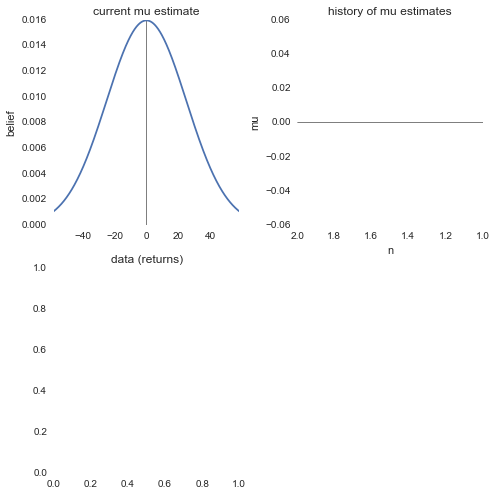

In [6]:
interactive(gen_plot, n=(0, 600), bayes=True)

## Approximating the posterior with MCMC sampling

In [80]:
def plot_want_get():
    from scipy import stats
    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(121, title='What we want', ylim=(0, .5), xlabel='', ylabel='')
    ax1.plot(np.linspace(-4, 4, 100), stats.norm.pdf(np.linspace(-3, 3, 100)), lw=4.)
    ax2 = fig.add_subplot(122, title='What we get')#, xlim=(-4, 4), ylim=(0, 1800), xlabel='', ylabel='\# of samples')
    sns.distplot(np.random.randn(50000), ax=ax2, kde=False, norm_hist=True);
    ax2.set_xlim((-4, 4));
    ax2.set_ylim((0, .5));

## Approximating the posterior with MCMC sampling

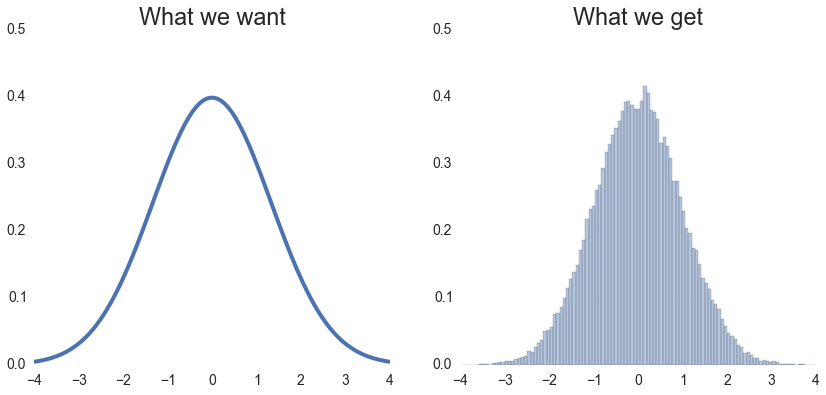

In [81]:
plot_want_get()

PyMC3
=====

* Probabilistic Programming framework written in Python.
* Allows for construction of probabilistic models using intuitive syntax.
* Features advanced MCMC samplers.
* Fast: Just-in-time compiled by Theano.
* **Extensible**: easily incorporates custom MCMC algorithms and unusual probability distributions.
* Authors: John Salvatier, Chris Fonnesbeck, Thomas Wiecki
* Upcoming *beta* release!

<center><img src="http://www.iskonline.org/media/news/end_detour.gif"></center>

# Model returns distribution: Specifying our priors

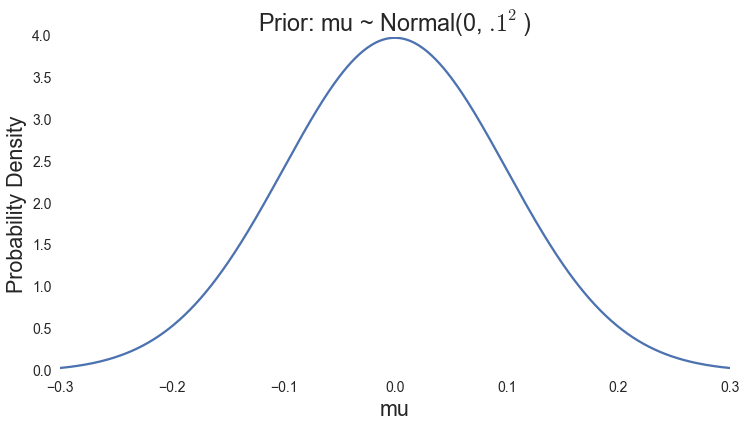

In [82]:
x = np.linspace(-.3, .3, 500)
plt.plot(x, T.exp(pm.Normal.dist(mu=0, sd=.1).logp(x)).eval())
plt.title(u'Prior: mu ~ Normal(0, $.1^2$)'); plt.xlabel('mu'); plt.ylabel('Probability Density'); plt.xlim((-.3, .3));

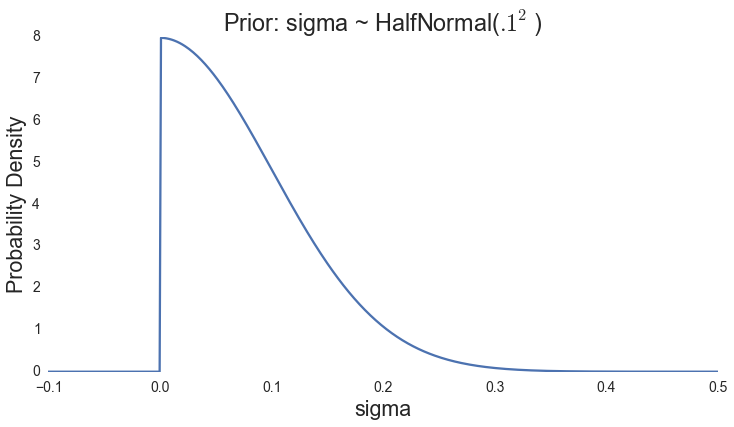

In [83]:
x = np.linspace(-.1, .5, 500)
plt.plot(x, T.exp(pm.HalfNormal.dist(sd=.1).logp(x)).eval())
plt.title(u'Prior: sigma ~ HalfNormal($.1^2$)'); plt.xlabel('sigma'); plt.ylabel('Probability Density');

## Bayesian Sharpe ratio

$\mu \sim \text{Normal}(0, .1^2)$ $\leftarrow \text{Prior}$

$\sigma \sim \text{HalfNormal}(.1^2)$ $\leftarrow \text{Prior}$

$\text{returns} \sim \text{Normal}(\mu, \sigma^2)$ $\leftarrow \text{Observed!}$

$\text{Sharpe} = \frac{\mu}{\sigma}$

## Graphical model of returns
<img width=80% src='bayes_formula_mu2.svg'>

## This is what the data looks like

In [9]:
print data_0.head()

2013-12-31 21:00:00    0.002143
2014-01-02 21:00:00   -0.028532
2014-01-03 21:00:00   -0.001577
2014-01-06 21:00:00   -0.000531
2014-01-07 21:00:00    0.011310
Name: 0, dtype: float64


In [14]:
from pymc3 import *

with Model() as model:
    # Priors on Random Variables
    mean_return = Normal('mean return', mu=0, sd=.1)
    volatility = HalfNormal('volatility', sd=.1)

    # Model returns as Normal
    obs = Normal('returns', 
                 mu=mean_return, 
                 sd=volatility,
                 observed=data_0)
    
    sharpe = Deterministic('sharpe ratio', 
                           mean_return / volatility * np.sqrt(252))

In [15]:
with model:
    # Instantiate MCMC sampler
    step = NUTS()
    # Draw 500 samples from the posterior
    trace = sample(500, step)

 [-----------------100%-----------------] 500 of 500 complete in 0.4 sec

# Analyzing the posterior

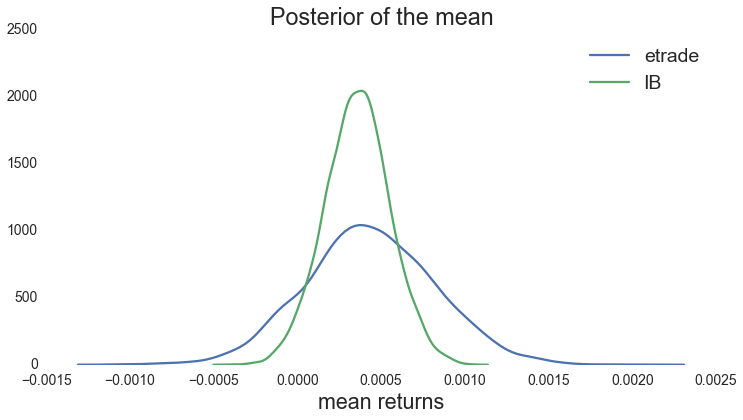

In [84]:
sns.distplot(results_normal[0][0]['mean returns'], hist=False, label='etrade')
sns.distplot(results_normal[1][0]['mean returns'], hist=False, label='IB')
plt.title('Posterior of the mean'); plt.xlabel('mean returns')

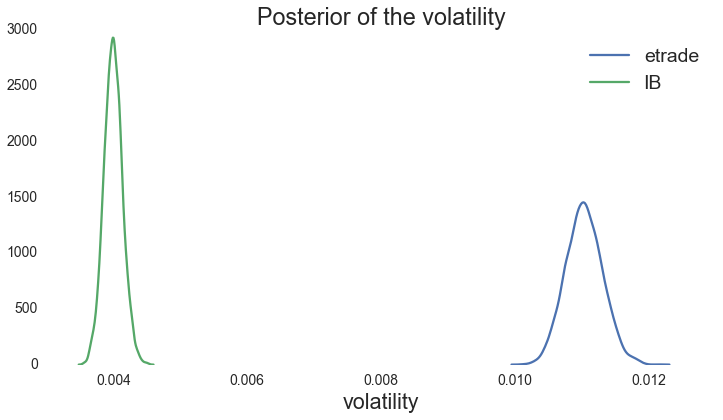

In [85]:
sns.distplot(results_normal[0][0]['volatility'], hist=False, label='etrade')
sns.distplot(results_normal[1][0]['volatility'], hist=False, label='IB')
plt.title('Posterior of the volatility')
plt.xlabel('volatility')

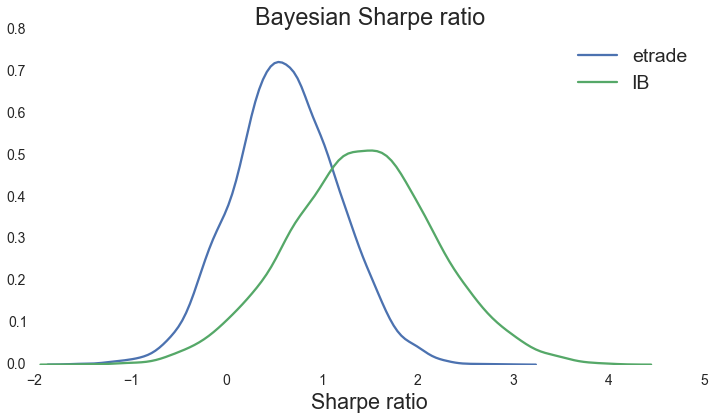

In [86]:
sns.distplot(results_normal[0][0]['sharpe'], hist=False, label='etrade')
sns.distplot(results_normal[1][0]['sharpe'], hist=False, label='IB')
plt.title('Bayesian Sharpe ratio'); plt.xlabel('Sharpe ratio');

In [28]:
print 'P(Sharpe ratio IB > 0) = %.2f%%' % \
    (np.mean(results_normal[1][0]['sharpe'] > 0) * 100)

P(Sharpe ratio IB > 0) = 96.48%


In [29]:
print 'P(Sharpe ratio IB > Sharpe ratio etrade) = %.2f%%' % \
    (np.mean(results_normal[1][0]['sharpe'] > results_normal[0][0]['sharpe']) * 100)

P(Sharpe ratio IB > Sharpe ratio etrade) = 80.06%


# Value at Risk with uncertainty

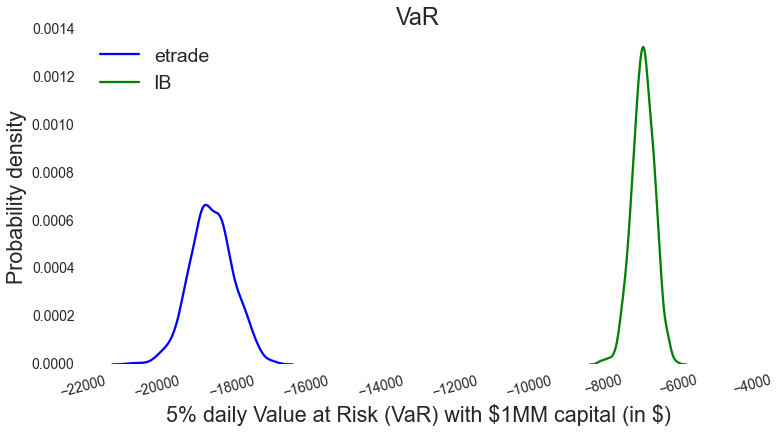

In [88]:
ppc_etrade = post_pred(var_cov_var_normal, results_normal[0][0], 1e6, .05, samples=800)
ppc_ib = post_pred(var_cov_var_normal, results_normal[1][0], 1e6, .05, samples=800)
sns.distplot(ppc_etrade, label='etrade', norm_hist=True, hist=False, color='b')
sns.distplot(ppc_ib, label='IB', norm_hist=True, hist=False, color='g')
plt.title('VaR'); plt.legend(loc=0); plt.xlabel('5% daily Value at Risk (VaR) with \$1MM capital (in \$)'); plt.ylabel('Probability density'); plt.xticks(rotation=15);

# Interim summary
* **Bayesian stats** allows us to **reformulate common risk metrics**, use **priors** and **quantify uncertainty**.
* IB strategy seems better in almost every regard. Is it though?

# So far, only added confidence

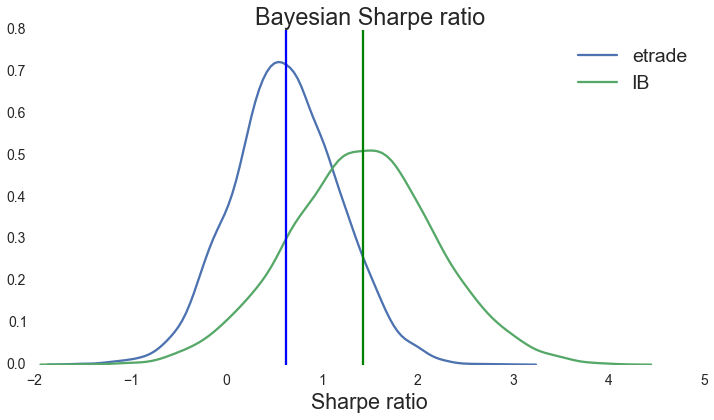

In [89]:
sns.distplot(results_normal[0][0]['sharpe'], hist=False, label='etrade')
sns.distplot(results_normal[1][0]['sharpe'], hist=False, label='IB')
plt.title('Bayesian Sharpe ratio'); plt.xlabel('Sharpe ratio');
plt.axvline(data_0.mean() / data_0.std() * np.sqrt(252), color='b');
plt.axvline(data_1.mean() / data_1.std() * np.sqrt(252), color='g');

In [92]:
x = np.linspace(-.03, .03, 500)
ppc_dist_normal = post_pred(eval_normal, results_normal[1][0], x=x)
ppc_dist_t = post_pred(eval_t, results_t[1][0], x=x)

# Is this a good model?

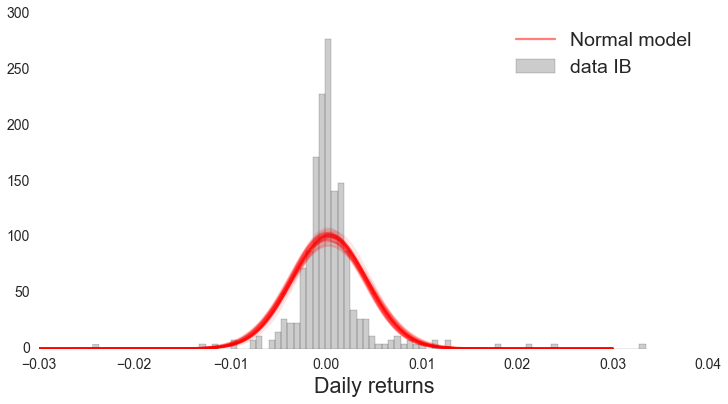

In [93]:
sns.distplot(data_1, label='data IB', kde=False, norm_hist=True, color='.5')
for p in ppc_dist_normal:
    plt.plot(x, p, c='r', alpha=.1)
plt.plot(x, p, c='r', alpha=.5, label='Normal model')
plt.xlabel('Daily returns')
plt.legend();

# Can it be improved? Yes!

Identical model as before, but instead, use a heavy-tailed T distribution:

$ \text{returns} \sim \text{T}(\nu, \mu, \sigma^2)$

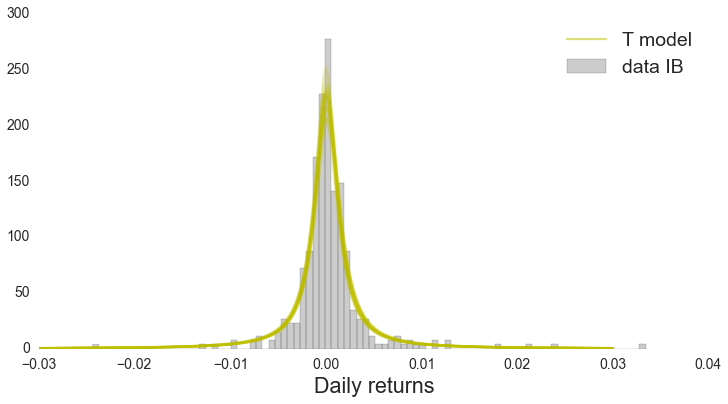

In [94]:
sns.distplot(data_1, label='data IB', kde=False, norm_hist=True, color='.5')
for p in ppc_dist_t:
    plt.plot(x, p, c='y', alpha=.1)
plt.plot(x, p, c='y', alpha=.5, label='T model')    
plt.xlabel('Daily returns')
plt.legend();

# Volatility

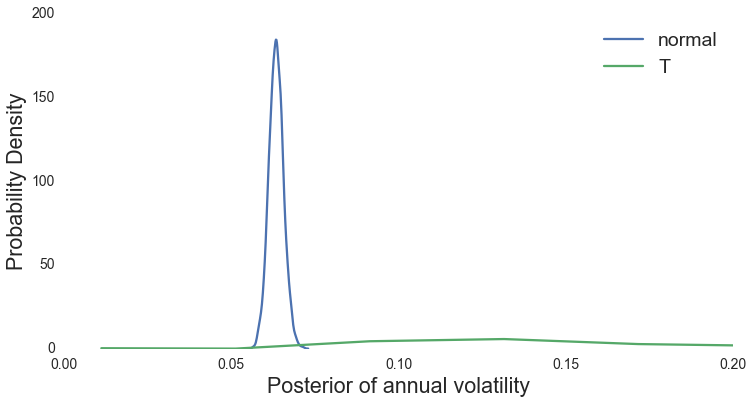

In [95]:
sns.distplot(results_normal[1][0]['annual volatility'], hist=False, label='normal')
sns.distplot(results_t[1][0]['annual volatility'], hist=False, label='T')
plt.xlim((0, 0.2))
plt.xlabel('Posterior of annual volatility')
plt.ylabel('Probability Density');

# Lets compare posteriors of the normal and T model

# Mean returns

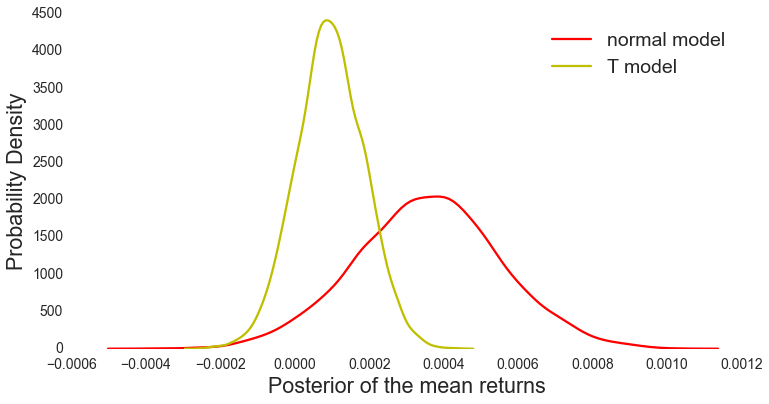

In [96]:
sns.distplot(results_normal[1][0]['mean returns'], hist=False, color='r', label='normal model')
sns.distplot(results_t[1][0]['mean returns'], hist=False, color='y', label='T model')
plt.xlabel('Posterior of the mean returns'); plt.ylabel('Probability Density');

# Bayesian T-Sharpe ratio

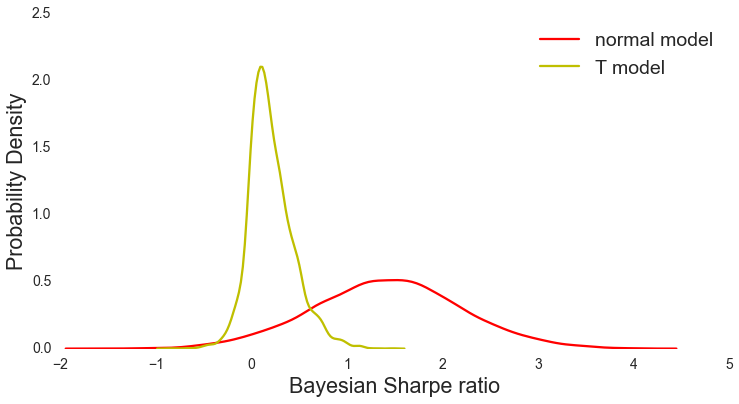

In [97]:
sns.distplot(results_normal[1][0]['sharpe'], hist=False, color='r', label='normal model')
sns.distplot(results_t[1][0]['sharpe'], hist=False, color='y', label='T model')
plt.xlabel('Bayesian Sharpe ratio'); plt.ylabel('Probability Density');

# But why? T distribution is more robust!

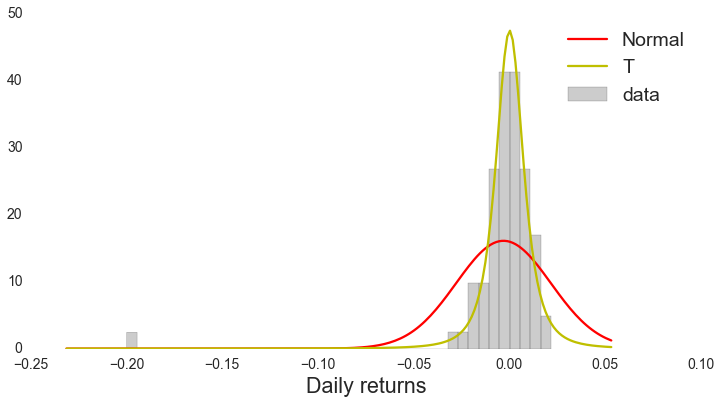

In [98]:
sim_data = list(np.random.randn(75)*.01)
sim_data.append(-.2)
sns.distplot(sim_data, label='data', kde=False, norm_hist=True, color='.5'); sns.distplot(sim_data, label='Normal', fit=stats.norm, kde=False, hist=False, fit_kws={'color': 'r', 'label': 'Normal'}); sns.distplot(sim_data, fit=stats.t, kde=False, hist=False, fit_kws={'color': 'y', 'label': 'T'})
plt.xlabel('Daily returns'); plt.legend();

# Estimating tail risk using VaR

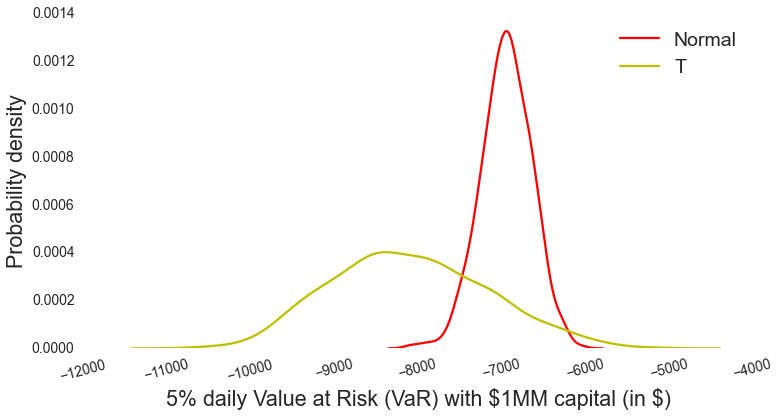

In [99]:
ppc_normal = post_pred(var_cov_var_normal, trace_normal, 1e6, .05, samples=800)
ppc_t = post_pred(var_cov_var_t, trace_t, 1e6, .05, samples=800)
sns.distplot(ppc_normal, label='Normal', norm_hist=True, hist=False, color='r')
sns.distplot(ppc_t, label='T', norm_hist=True, hist=False, color='y')
plt.legend(loc=0); plt.xlabel('5% daily Value at Risk (VaR) with \$1MM capital (in \$)'); plt.ylabel('Probability density'); plt.xticks(rotation=15);

# Comparing the Bayesian T-Sharpe ratios

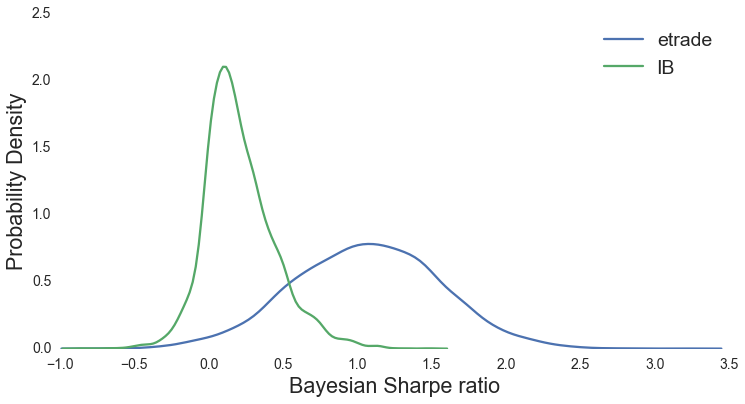

In [101]:
sns.distplot(results_t[0][0]['sharpe'], hist=False, label='etrade')
sns.distplot(results_t[1][0]['sharpe'], hist=False, label='IB')
plt.xlabel('Bayesian Sharpe ratio'); plt.ylabel('Probability Density');

In [42]:
print 'P(Sharpe ratio IB > Sharpe ratio etrade) = %.2f%%' % \
    (np.mean(results_t[1][0]['sharpe'] > results_t[0][0]['sharpe']) * 100)

P(Sharpe ratio IB > Sharpe ratio etrade) = 5.86%


Conclusions
===========

* **Probabilistic Programming** allows us to construct **complex models** in code and **automatically** estimate them.
* **Bayesian statistics** provides us with **uncertainty quantification** -- measure orthogonal sources of **risk**.
* **PyMC3** puts **advanced samplers** at your fingertips.

# Further reading

* [Quantopian](https://www.quantopian.com) -- Develop trading algorithms like this in your browser.
* [My blog for Bayesian linear regression (financial alpha and beta)](https://twiecki.github.io)
* [Probilistic Programming for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) -- IPython Notebook book on Bayesian stats using PyMC2.
* [Doing Bayesian Data Analysis](http://www.indiana.edu/~kruschke/DoingBayesianDataAnalysis/) -- Great book by Kruschke.
* [PyMC3 repository](https://github.com/pymc-devs/pymc3)
* Twitter: [@twiecki](https://twitter.com/twiecki)